# Амиров Дмитрий, РИ-400024, HW_2

- Выберите для анализа один из двух временных рядов: данные об осадках или данные о продажах в онлайн-ритейлере

В качестве объекта анализа был выбран датасет с данными об осадках rainfall.csv

Для чтения датасета и дальнейщего анализа нужно импортировать необходимые библиотеки:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import shap

from itertools import product
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from lime import lime_tabular

%matplotlib inline

Чтение датасета:

In [2]:
df_amirov = pd.read_csv('rainfall.csv', index_col=['date'], parse_dates=['date'])
df_amirov

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510
...,...
2019-11-11,6.737
2019-11-21,5.216
2019-12-01,2.022


- Визуализируйте ряд и на основе его внешнего вида сделайте предположения о его компонентах (тренд, сезонность) и стационарности - 1 балл

Осуществлена группировка данных по месяцам, вычиление среднего значения для каждого месяца и удаление строк с отсутствующими значениями:

In [3]:
df_amirov = df_amirov.resample('M').mean().dropna()
df_amirov

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333
...,...
2019-08-31,174.259000
2019-09-30,83.920000
2019-10-31,44.260333


Визуализация временного ряда:

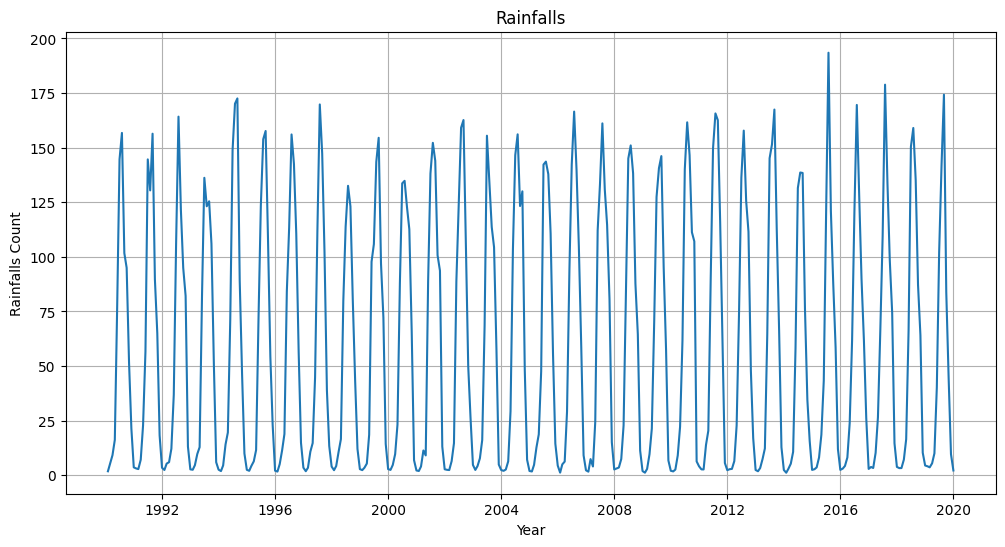

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df_amirov.mean_rainfall)
plt.title('Rainfalls')
plt.xlabel('Year')
plt.ylabel('Rainfalls Count')
plt.grid(True)
plt.show()

- Сделайте train/test split

Ряд не стационарен, так как наблюдается рост осадков в начале года и спад к концу года, тренд не выявлен.

In [5]:
def train_test_split(df_amirov, test_size):

    test_index = int(len(df_amirov)*(1-test_size))

    df_amirov_train = df_amirov.iloc[:test_index]
    df_amirov_test = df_amirov.iloc[test_index:]

    return df_amirov_train, df_amirov_test


df_amirov_train, df_amirov_test = train_test_split(df_amirov, test_size=0.3)

# Бейзлайн

- Постройте бейзлайн в виде наивного прогноза или скользящего среднего - 2 балла

In [6]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_amirov_train, 3)

74.88077777777778

In [7]:
df_amirov_test.head(1)

,mean_rainfall
date,
2010-12-31,4.079667


- Визуализируйте результаты работы модели, произведите замеры качества бейзлайна с релевантной, на ваш взгляд, метрикой - 1 балл

Визуализация результатов работы модели с окном в 4 месяца:

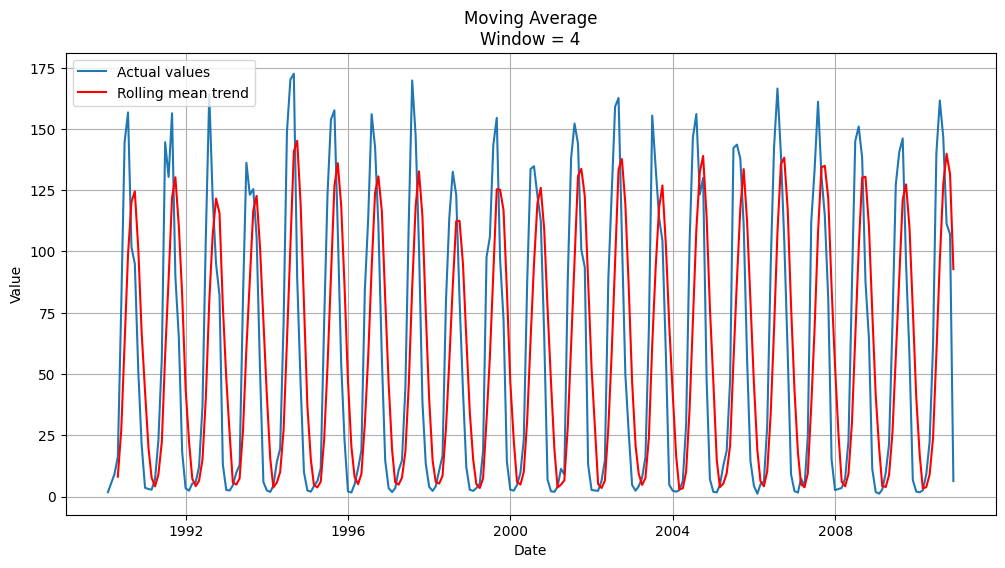

In [8]:
def plot_moving_average(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Actual values')
    plt.plot(rolling_mean.index, rolling_mean, 'r', label='Rolling mean trend')
    plt.title('Moving Average\nWindow = {}'.format(window))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(df_amirov_train, 4)

Замеры качества бейзлайна. Для этого осуществлен расчет MAE:

In [9]:
mean_absolute_error([moving_average(df_amirov_train, 4)], df_amirov_test.head(1))

88.71700000000001

Вывод: MAE = 88.71700000000001 => средняя абсолютная ошибка между прогнозируемыми значениями, полученными с помощью скользящего среднего с окном 4 на обучающем наборе данных, и фактическими значениями, представленными первым элементом тестового набора данных, составляет примерно 88.717. Ошибка такого размера указывает на то, что модель, использующая скользящее среднее с окном 4, не совсем точно предсказывает значения тестового набора данных.

# Статистическая модель

- Проведите тест Дики-Фуллера и интерпретируйте результаты - 1 балл

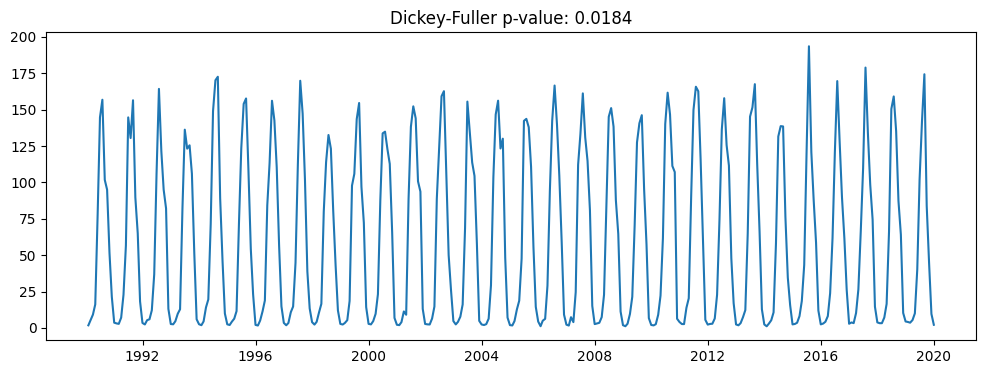

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(df_amirov)
plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(df_amirov_train)[1], 4)))
plt.show()

Вывод: маленькое значение p-значения теста Дики-Фуллера (0.0184) указывает на высокую вероятность стационарности временного ряда, что говорит о том, что в ряду отсутствуют единичные корни.

- Постройте графики ACF/PACF и проанализируйте их, сделайте предположения о наличии/отсутствии сезонности - 1 балл

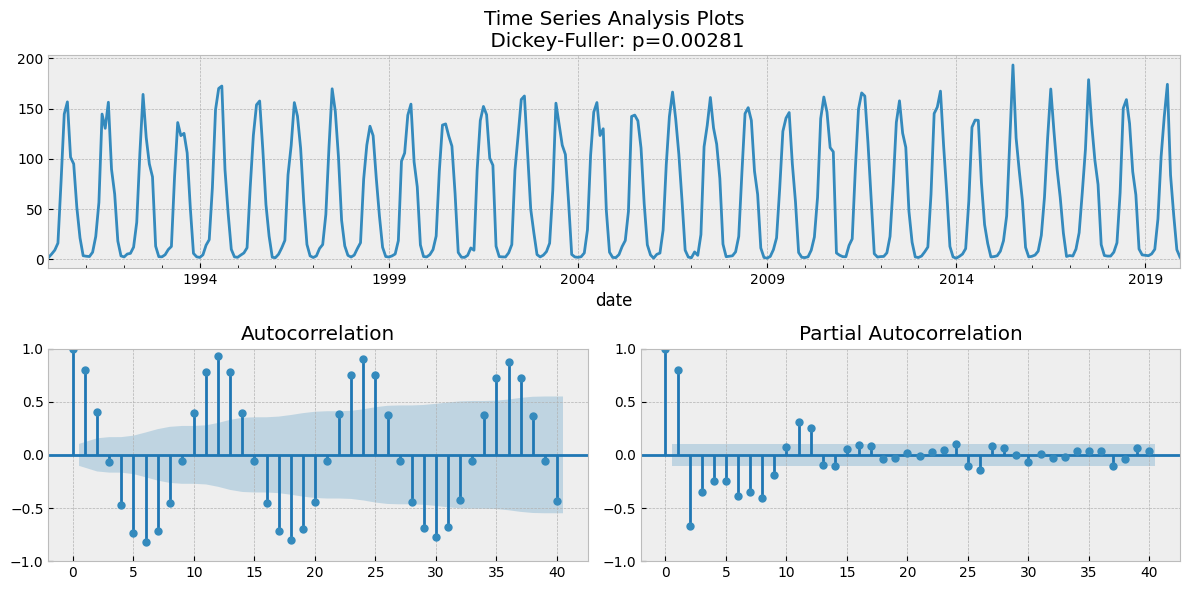

In [11]:
def tsplot(y, lags=None, figsize=(12, 6), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df_amirov.mean_rainfall, lags=40)

Вывод: на графике Autocorrelation можно заметить, что продолжительность сезонности 1 год.

- Проведите необходимые на ваш взгляд преобразования для придания ряду стационарности (дифференцирование / сезонное дифференцирование) - 3 балла

Осуществеление сезонного дифференцирования:

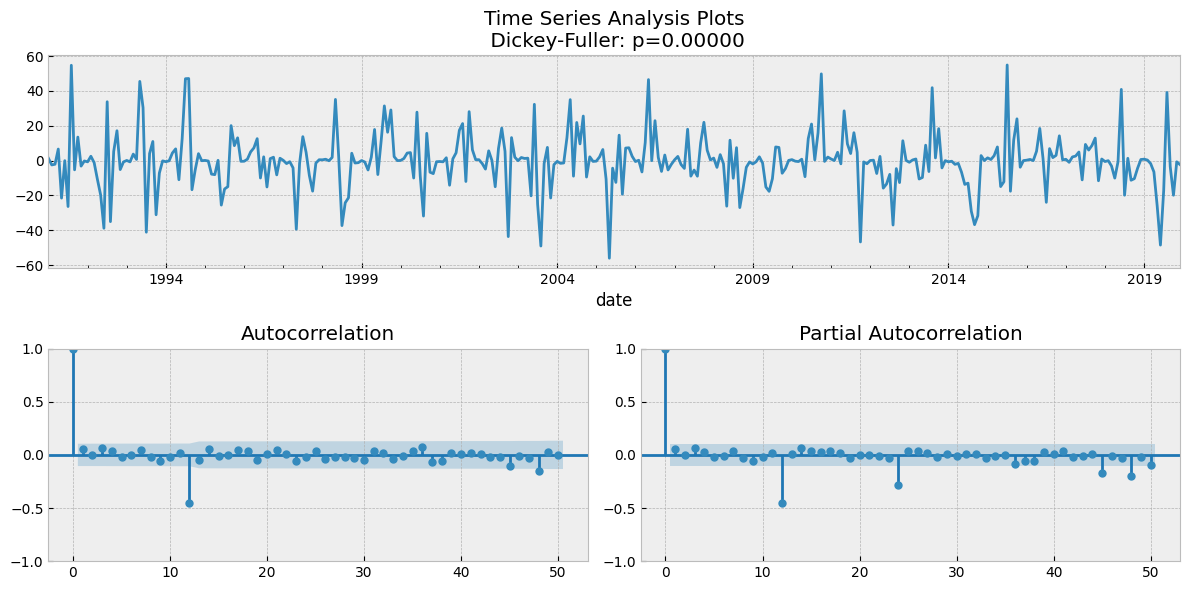

In [12]:
df_amirov_diff = df_amirov.mean_rainfall - df_amirov.mean_rainfall.shift(12)
tsplot(df_amirov_diff[12:], lags=50)

- Проверьте стационарность полученного ряда с тестом Дики-Фуллера и визуализацией ACF/PACF - 1 балл

Вывод: тест Дики-Фуллера и визуализация ACF/PACF указывают на стационарность ряда.

- Обучите модель ARIMA или SARIMA для прогнозирования значений ряда, подобрав оптимальные параметры - 5 баллов

Осуществлено обучение модели SARIMA

In [13]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(df_amirov.mean_rainfall, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

d = 0 
D = 1 
s = 12 

ps = range(2, 4)
qs = range(2, 4)
Ps = range(0, 2)
Qs = range(2, 3)


parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

Вышла ошибка - "IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...". Для решения данной проблемы в терминале необходимо прописать следующие команды: pip install --upgrade jupyter ipywidgets; jupyter nbextension enable --py widgetsnbextension


In [14]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/8 [00:00<?, ?it/s]

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


CPU times: total: 8.58 s
Wall time: 32 s


In [15]:
result_table.head()

,parameters,aic
0,"(3, 3, 1, 2)",2744.552094
1,"(3, 3, 0, 2)",2744.558093
2,"(3, 2, 1, 2)",2745.672406
3,"(2, 3, 1, 2)",2746.499678
4,"(2, 2, 1, 2)",2749.567774


In [16]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_amirov_train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

Maximum Likelihood optimization failed to converge. Check mle_retvals


                                        SARIMAX Results                                        
Dep. Variable:                           mean_rainfall   No. Observations:                  251
Model:             SARIMAX(3, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood                -939.370
Date:                                 Mon, 04 Mar 2024   AIC                           1898.739
Time:                                         13:21:08   BIC                           1933.504
Sample:                                     01-31-1990   HQIC                          1912.748
                                          - 11-30-2010                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4806      0.975      0.493      0.622      -1.430       2

- Визуализируйте результаты работы модели, произведите замеры качества модели ARIMA (или SARIMA), сравните с бейзлайном - 1 балл

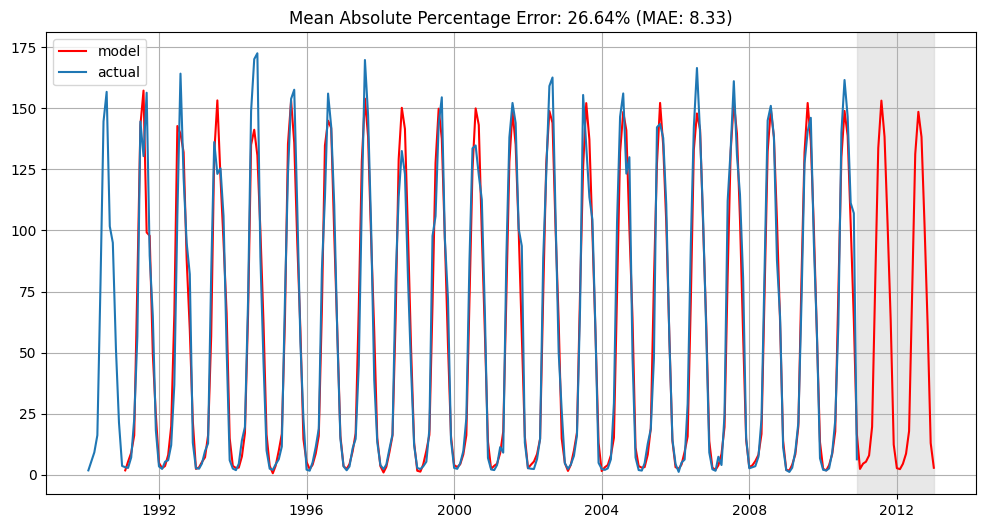

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):

    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model._append(forecast)
    error1 = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    error2 = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(12, 6))
    plt.title(f"Mean Absolute Percentage Error: {round(error1, 2)}% (MAE: {round(error2, 2)})")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

plotSARIMA(df_amirov_train, best_model, 24)

Вывод: так как MAE = 8.33 => средняя абсолютная ошибка стала меньше по сравнению с Baseline в 10 раз (MAE = 88.71700000000001), значит результаты улучшились.

# Классическая модель

- Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc) - 5 баллов

Создание 36 признаков под сезонность временного ряда:

In [18]:
data = pd.DataFrame(df_amirov.mean_rainfall.copy())
data.columns = ["y"]

for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

Создание признаков дня и месяца:

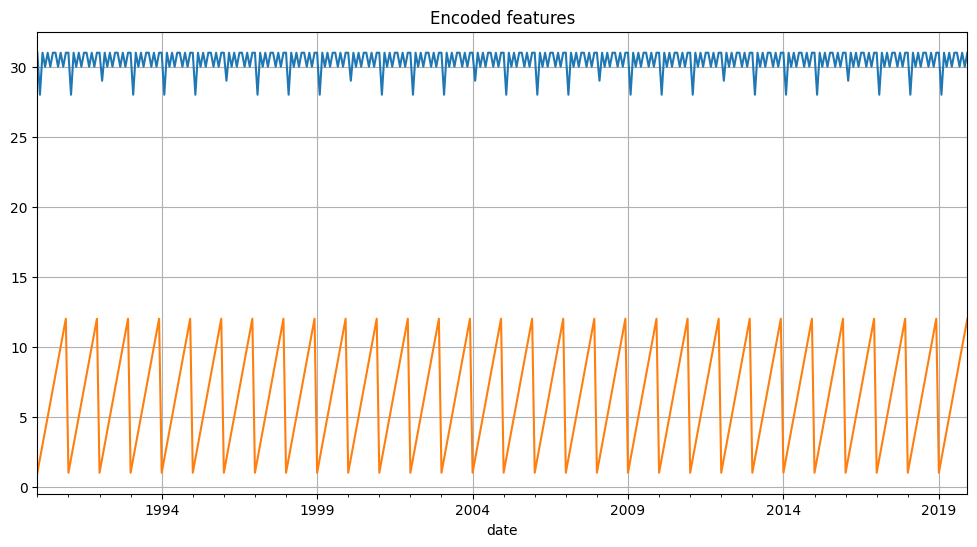

In [19]:
data['day'] = data.index.day
data['month'] = data.index.month
plt.figure(figsize=(12, 6))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
plt.grid(True);

- На полученном наборе данных обучите случайный лес или градиентный бустинг - 2 балла

In [20]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [21]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [22]:
regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

- Визуализируйте результаты работы модели, произведите замеры качества модели, сравните с прошлыми экспериментами - 1 балл

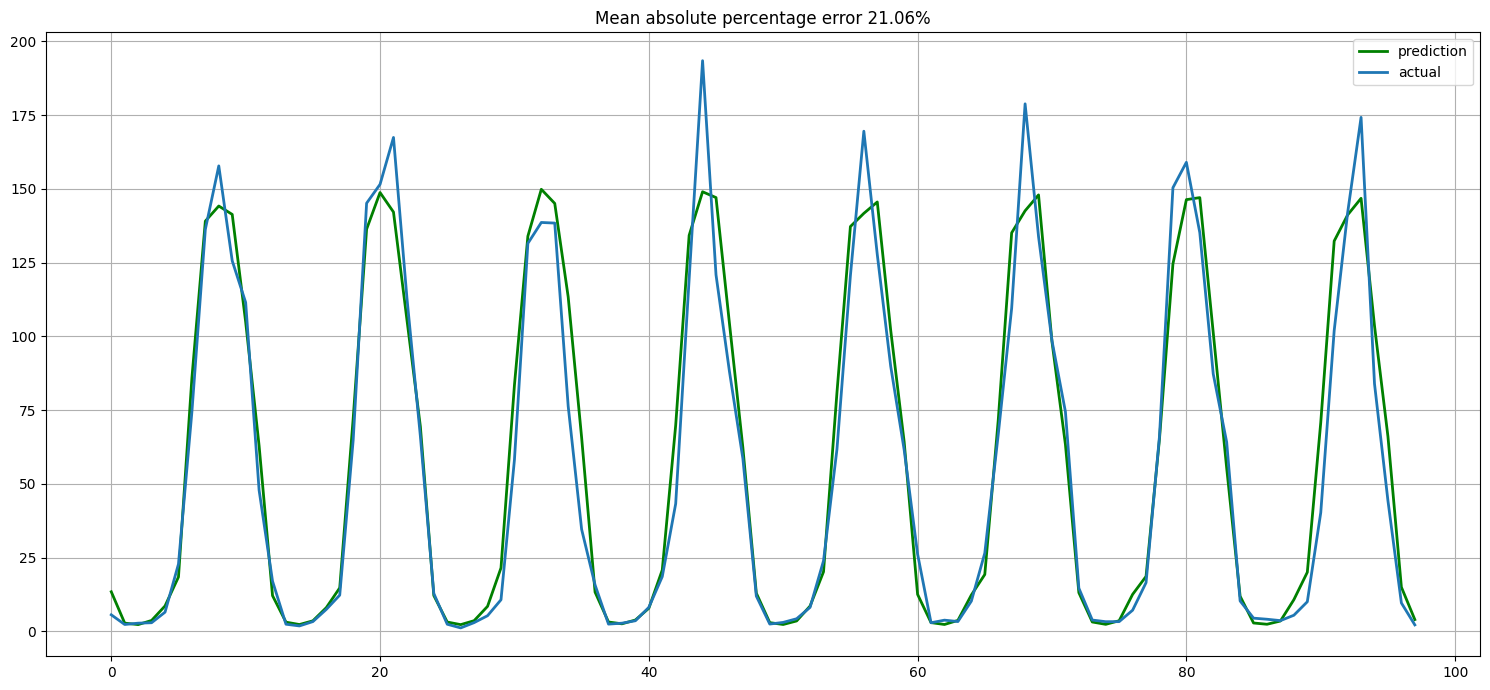

In [23]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

Вывод: MAE = 21.06%. Это меньше, чем результат Sarima (MAE = 26.64%).

# Интерпретация

Проинтерпретируйте модель, полученную в шаге Классическая модель с помощью:

    permutation importance - 3 балла
    LIME - 3 балла
    SHAP - локальная интерпретация (для одного объекта) - 2 балла
    SHAP - глобальная интерпретация (для всей модели целиком) - 2 балла

Сделайте выводы о результатах интерпретации

Интерпритация модели с помощью permutation importance:

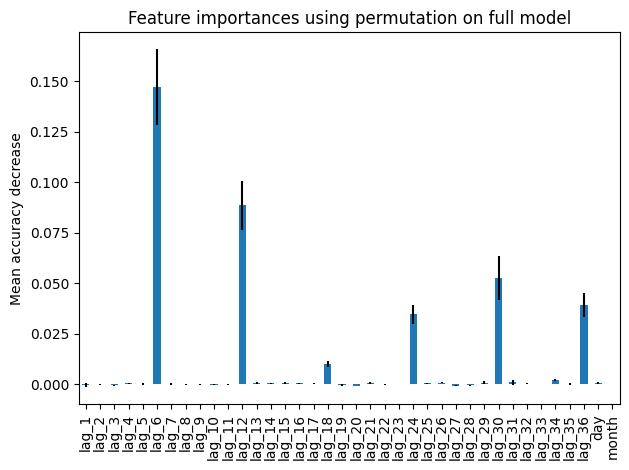

In [24]:
importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Интерпритация модели с помощью lime:

In [25]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 39.90000876411967
Prediction_local [128.25430709]
Right: 145.07163060270784


In [26]:
exp.show_in_notebook(show_table=True)

In [27]:
exp.as_list()

[('lag_6 <= 4.99', 29.45890622815384),
 ('lag_12 > 112.52', 19.6130825085914),
 ('lag_30 <= 5.14', 14.131248088716037),
 ('lag_36 > 112.01', 13.402917345856656),
 ('lag_24 > 112.52', 11.748144157618425)]

SHAP - локальная интерпретация (для одного объекта):

In [28]:
explainer = shap.TreeExplainer(regr)

In [29]:
choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [30]:
choosen_instance = X_test.iloc[[27]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

SHAP - глобальная интерпретация (для всей модели целиком):

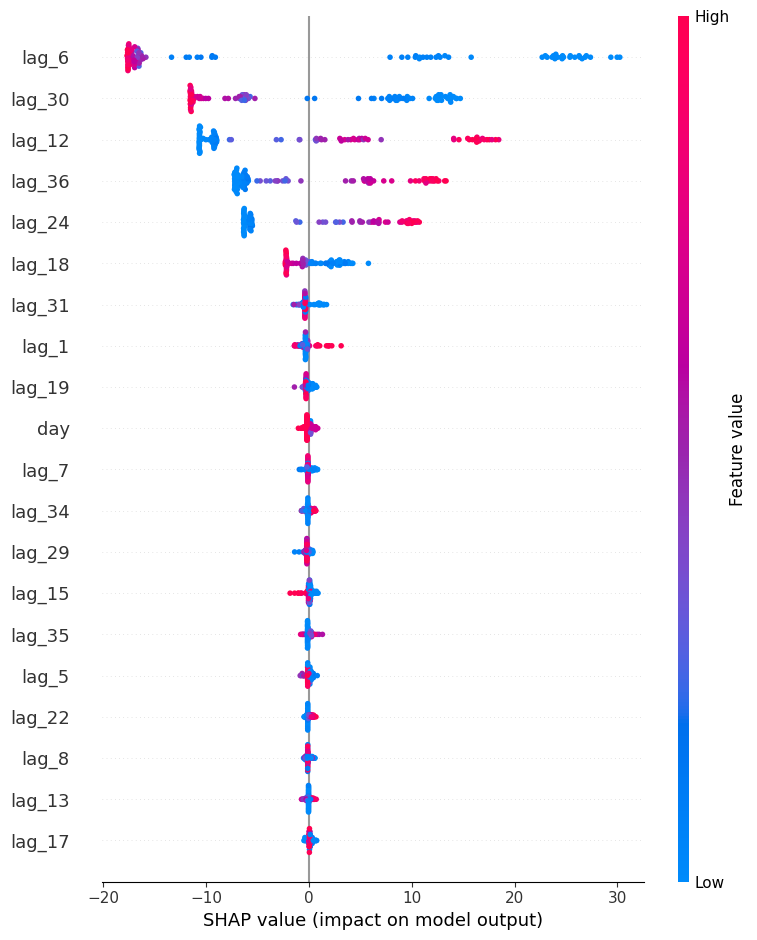

In [31]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

# Вывод: на основании результатов различных анализов можно сделать вывод, что наилучшими интервалами для исследования являются значения, которые либо делятся на период (12 интервалов), либо являются его кратными - 6, 12, 24 и 36.